In [2]:
# =============================================================================
# 1. CONFIGURACIÓN E IMPORTACIONES
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
import joblib

# Modelos y Métricas
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
#  Habilitar explícitamente la característica experimental
from sklearn.experimental import enable_iterative_imputer 
# importar el imputador
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from linearmodels.panel import PanelOLS, RandomEffects # pip install linearmodels
import statsmodels.api as sm

# Configuración
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
SEED = 42
np.random.seed(SEED)

In [ ]:
# =============================================================================
# 2. CARGA DE DATOS Y PREPARACIÓN
# =============================================================================
# Carga tus datos (Asegúrate de tener el CSV actualizado)
url = "https://raw.githubusercontent.com/rortizgeo/Maestria_CD_Proyecto-Aplicado/main/Data_final.csv"
# Fallback local por si acaso
try:
    df_raw = pd.read_csv(url)
except:
    df_raw = pd.read_csv("Data_final.csv") # Si lo tienes local

# Limpieza básica
df_raw['ds'] = pd.to_datetime(df_raw['year'], format='%Y')
df_raw = df_raw.sort_values(by=['country', 'ds']).reset_index(drop=True)

TARGET = 'occurrenceCount_publisher'
# Transformación Logarítmica (Crucial para reducir varianza)
df_raw[TARGET] = np.log1p(df_raw[TARGET]) 

# Selección de Variables (Basado en tu análisis previo)

features_base = [
    'gasto_RD_pib', 'efectividad_gobierno', 'uso_internet', 
    'pib_per_capita', 'inscripcion_primaria', 'inscripcion_terciaria',
    'gasto_educacion_pib', 'investigadores_RD', 'art_cientificos'
]

print("Datos cargados. Target transformado (log1p).")

Datos cargados. Target transformado (log1p).


In [4]:
# =============================================================================
# 3. MÓDULO DE DIAGNÓSTICO (FE & LASSO) - LA "VALIDACIÓN TEÓRICA"
# =============================================================================
def run_diagnostics(df, features):
    print("\n--- EJECUTANDO DIAGNÓSTICO DE VARIABLES ---")
    
    # 1. Efectos Fijos (Panel FE)
    # Preparamos datos de panel
    df_panel = df.set_index(['country', 'year'])
    exog = sm.add_constant(df_panel[features])
    mod_fe = PanelOLS(df_panel[TARGET], exog, entity_effects=True)
    res_fe = mod_fe.fit(cov_type='clustered', cluster_entity=True)
    
    print("\n>>> Resultados Clave Efectos Fijos (Significancia):")
    print(res_fe.params[res_fe.pvalues < 0.1]) # Solo mostramos las significativas al 10%
    
    # 2. Lasso Global (Selección de Features)
    # Imputamos simples para el diagnóstico
    imp = IterativeImputer(random_state=SEED)
    X_imp = imp.fit_transform(df[features])
    y = df[TARGET]
    
    lasso = LassoCV(cv=5, random_state=SEED).fit(X_imp, y)
    coef_lasso = pd.Series(lasso.coef_, index=features)
    print("\n>>> Top Variables según Lasso:")
    print(coef_lasso[coef_lasso != 0].sort_values(ascending=False))
    
    return res_fe, list(coef_lasso[coef_lasso != 0].index)

# Ejecutamos Diagnóstico
fe_model, top_features_lasso = run_diagnostics(df_raw, features_base)


--- EJECUTANDO DIAGNÓSTICO DE VARIABLES ---

>>> Resultados Clave Efectos Fijos (Significancia):
uso_internet           0.187202
gasto_educacion_pib    0.586144
investigadores_RD      0.000688
Name: parameter, dtype: float64

>>> Top Variables según Lasso:
investigadores_RD    0.001244
art_cientificos      0.000018
pib_per_capita      -0.000017
dtype: float64


In [5]:
# =============================================================================
# 4. INGENIERÍA DE CARACTERÍSTICAS (PARA EL MODELO PREDICTIVO ML)
# =============================================================================
def create_features(df, features_input, lags=[1, 3], roll_win=[3]):
    """
    Crea lags y rolling windows. Es fundamental volver a llamar a esta función
    dentro del bucle de predicción recursiva.
    """
    df_out = df.copy()
    # Lags y Rolling de variables exógenas Y del Target
    vars_to_transform = features_input + [TARGET]
    
    for col in vars_to_transform:
        for l in lags:
            df_out[f'{col}_lag{l}'] = df_out.groupby('country')[col].shift(l)
        for w in roll_win:
            # Rolling sobre el shift(1) para evitar data leakage
            df_out[f'{col}_roll_mean{w}'] = df_out.groupby('country')[col].shift(1).rolling(w).mean()
    
    return df_out

# Creamos dataset con features para entrenamiento
df_ml = create_features(df_raw, features_base)
# Eliminamos NaNs generados por lags (necesario para entrenar)
df_ml_train_ready = df_ml.dropna()

print(f"\nDataset listo para ML. Dimensiones: {df_ml_train_ready.shape}")


Dataset listo para ML. Dimensiones: (410, 53)


In [6]:
# =============================================================================
# 5. ENTRENAMIENTO Y SELECCIÓN DEL MEJOR MODELO
# =============================================================================
def train_evaluate_models(df, features_cols, target_col):
    print("\n--- ENTRENANDO MODELOS PREDICTIVOS (RF & XGB) ---")
    
    # Separamos X e y
    # Usamos todas las columnas numéricas generadas (lags, rolls, base)
    valid_cols = [c for c in df.columns if c not in ['country', 'year', 'ds', target_col] and df[c].dtype in ['float64', 'int64']]
    
    X = df[valid_cols]
    y = df[target_col]
    
    # TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    
    results = []
    
    # Modelos base
    models = {
        'RandomForest': RandomForestRegressor(n_estimators=200, max_depth=10, random_state=SEED, n_jobs=-1),
        'XGBoost': xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=SEED, n_jobs=-1)
    }
    
    best_model_global = None
    best_mae_global = float('inf')
    
    # Loop de validación
    for name, model in models.items():
        maes = []
        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            
            # Métricas en escala original (expm1)
            mae = mean_absolute_error(np.expm1(y_test), np.expm1(preds))
            maes.append(mae)
        
        avg_mae = np.mean(maes)
        print(f"Modelo: {name} | MAE Promedio (Validación): {avg_mae:.2f}")
        
        if avg_mae < best_mae_global:
            best_mae_global = avg_mae
            best_model_global = model # Guardamos la última instancia entrenada o reentrenamos al final
            best_name = name
            
    print(f"\n🏆 MEJOR MODELO SELECCIONADO: {best_name}")
    
    # Reentrenar el mejor modelo con TODOS los datos disponibles
    best_model_global.fit(X, y)
    
    return best_model_global, list(X.columns)

# Entrenamos
best_model, feature_cols_final = train_evaluate_models(df_ml_train_ready, features_base, TARGET)


--- ENTRENANDO MODELOS PREDICTIVOS (RF & XGB) ---
Modelo: RandomForest | MAE Promedio (Validación): 12353665.21
Modelo: XGBoost | MAE Promedio (Validación): 14545388.48

🏆 MEJOR MODELO SELECCIONADO: RandomForest


In [7]:
# =============================================================================
# 6. MOTOR DE PROYECCIÓN Y ESCENARIOS 
# =============================================================================

def project_exogenous_variables(df_hist, country, years_future, scenario_multipliers={}):
    """
    Proyecta las variables independientes (PIB, Internet, etc.) hacia el futuro.
    Aplica multiplicadores para escenarios (ej. internet * 1.10).
    """
    last_year = df_hist['year'].max()
    future_data = []
    
    df_country = df_hist[df_hist['country'] == country].sort_values('year')
    
    for yr in years_future:
        row = {'country': country, 'year': yr}
        
        for col in features_base:
            # 1. Proyección Base: Tendencia Lineal simple de los últimos 5 años
            # (Para tesis, podrías usar HoltWinters aquí si quisieras más sofisticación)
            history = df_country[col].tail(5).values
            if len(history) > 1:
                z = np.polyfit(range(len(history)), history, 1)
                p = np.poly1d(z)
                next_val = p(len(history) + (yr - last_year) - 1)
            else:
                next_val = history[-1] # Fallback
            
            # 2. Aplicar Escenario (Multiplier)
            # Si la variable está en el diccionario de escenarios, la multiplicamos
            if col in scenario_multipliers:
                next_val = next_val * scenario_multipliers[col]
                
            # Limites lógicos (ej. internet no puede ser > 100 o < 0)
            if 'uso_internet' in col: next_val = np.clip(next_val, 0, 100)
            
            row[col] = next_val
            
        future_data.append(row)
        
        # Añadimos la fila simulada al histórico temporal para que la siguiente 
        # iteración de polyfit la tome en cuenta (tendencia dinámica)
        df_country = pd.concat([df_country, pd.DataFrame([row])], ignore_index=True)
        
    return pd.DataFrame(future_data)

def recursive_prediction_engine(model, df_hist, country, start_year, end_year, scenario_params={}):
    """
    Realiza la predicción año a año, recalculando lags en cada paso.
    """
    # 1. Copia de seguridad del histórico
    df_sim = df_hist[df_hist['country'] == country].copy()
    
    # 2. Proyectar variables exógenas (Internet, Educacion, etc.) hasta end_year
    future_years = list(range(start_year, end_year + 1))
    df_exog_future = project_exogenous_variables(df_sim, country, future_years, scenario_params)
    
    # Inicializamos columnas target en futuro como NaN
    df_exog_future[TARGET] = np.nan
    
    # Unimos (Ahora tenemos histórico completo + futuro sin target)
    df_sim = pd.concat([df_sim, df_exog_future], ignore_index=True)
    
    # 3. Bucle Recursivo
    for yr in future_years:
        # A. Recalcular Features (Lags, Rolling) con la data disponible hasta el momento
        # Esto es vital: usa los valores predichos de (yr-1) para calcular lag1 de (yr)
        df_features_dynamic = create_features(df_sim, features_base)
        
        # B. Obtener vector de entrada para el año actual
        row_to_predict = df_features_dynamic[df_features_dynamic['year'] == yr]
        
        # Verificar que tengamos las columnas exactas que el modelo aprendió
        X_input = row_to_predict[feature_cols_final]
        
        # C. Predecir
        pred_log = model.predict(X_input)[0]
        
        # D. Guardar predicción en el DataFrame maestro
        idx = df_sim[df_sim['year'] == yr].index
        df_sim.loc[idx, TARGET] = pred_log
        
    return df_sim

In [8]:
# =============================================================================
# 7. EJECUCIÓN DE ESCENARIOS: COLOMBIA 2024-2030
# =============================================================================
country_target = 'Colombia'
start_yr = 2023 # Asumiendo que tus datos terminan en 2022
end_yr = 2030

print(f"\n--- GENERANDO ESCENARIOS PARA {country_target.upper()} ({start_yr}-{end_yr}) ---")

# Escenario 1: Baseline (Tendencia actual continua)
df_base = recursive_prediction_engine(best_model, df_raw, country_target, start_yr, end_yr, scenario_params={})

# Escenario 2: "Impulso Digital y Educativo" (Política Pública)
# Suponemos que una política agresiva logra aumentar el uso de internet y gasto en educación un 10% por encima de la tendencia
scenario_policy = {
    'uso_internet': 1.10, 
    'gasto_educacion_pib': 1.10,
    'efectividad_gobierno': 1.05
}
df_opt = recursive_prediction_engine(best_model, df_raw, country_target, start_yr, end_yr, scenario_params=scenario_policy)


--- GENERANDO ESCENARIOS PARA COLOMBIA (2023-2030) ---


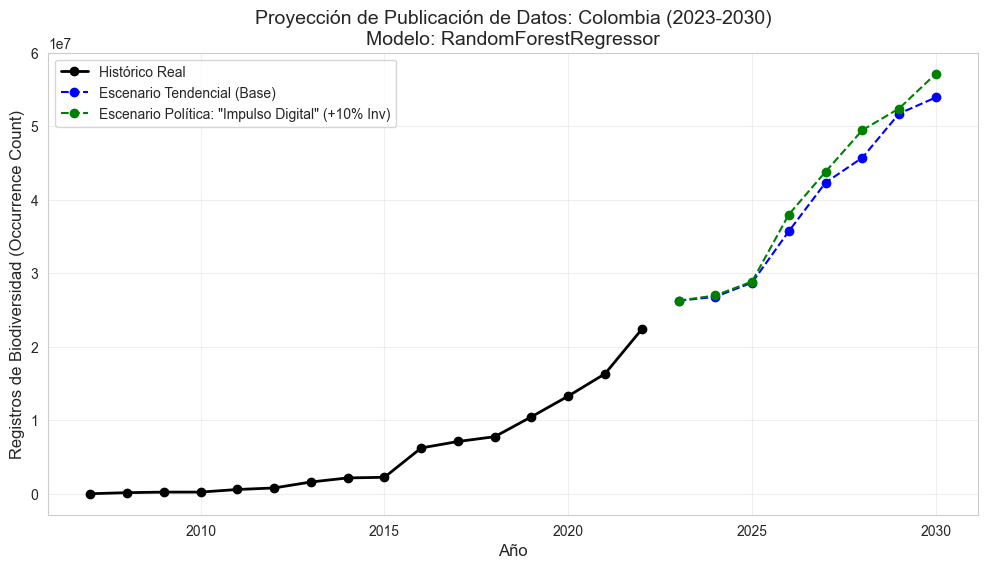


CONCLUSIÓN DEL SIMULADOR:
En 2030, el escenario de política genera 3,227,160 registros adicionales.
Esto representa un incremento del 5.98% sobre la tendencia actual.


In [9]:
# =============================================================================
# 8. VISUALIZACIÓN DE RESULTADOS
# =============================================================================
def plot_scenarios(df_base, df_opt, country):
    plt.figure(figsize=(12, 6))
    
    # Datos Históricos Reales
    hist_data = df_raw[df_raw['country'] == country]
    plt.plot(hist_data['year'], np.expm1(hist_data[TARGET]), 'k-o', label='Histórico Real', linewidth=2)
    
    # Escenario Base
    base_future = df_base[df_base['year'] >= start_yr]
    plt.plot(base_future['year'], np.expm1(base_future[TARGET]), 'b--o', label='Escenario Tendencial (Base)')
    
    # Escenario Optimista
    opt_future = df_opt[df_opt['year'] >= start_yr]
    plt.plot(opt_future['year'], np.expm1(opt_future[TARGET]), 'g--o', label='Escenario Política: "Impulso Digital" (+10% Inv)')
    
    plt.title(f'Proyección de Publicación de Datos: {country} (2023-2030)\nModelo: {best_model.__class__.__name__}', fontsize=14)
    plt.ylabel('Registros de Biodiversidad (Occurrence Count)', fontsize=12)
    plt.xlabel('Año', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calcular la diferencia
    val_base_2030 = np.expm1(base_future[TARGET].iloc[-1])
    val_opt_2030 = np.expm1(opt_future[TARGET].iloc[-1])
    diff = val_opt_2030 - val_base_2030
    perc = (diff / val_base_2030) * 100
    
    print(f"\nCONCLUSIÓN DEL SIMULADOR:")
    print(f"En 2030, el escenario de política genera {diff:,.0f} registros adicionales.")
    print(f"Esto representa un incremento del {perc:.2f}% sobre la tendencia actual.")

plot_scenarios(df_base, df_opt, country_target)